In [45]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

## 相位噪声模拟  
时间分辨率1us，采样率1MHz，模拟时间1s  
用布朗运动模拟相位噪声

      phase speed      phase
Mean    -0.000003 -10.174578
Std      0.013941   3.978187
Var      0.000194  15.825972


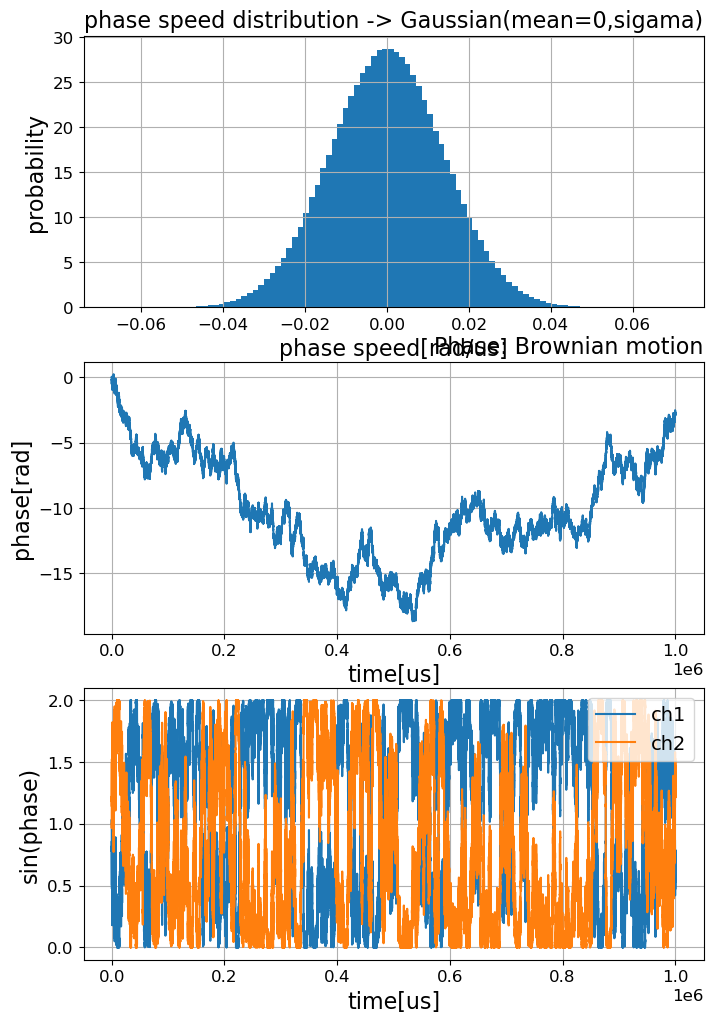

In [46]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.8/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

In [47]:
PHASE_SEEPD=0.8/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
RAND_NUM=10 # 随机模拟次数
time_axis=np.arange(0,1e5,1) #1us分辨率，len=1e5us  SR=1M
time_exposure=1000
RAND_SEED=2025

如果相位噪声满足独立随机分布，那么用var评估比较好，因为其关于时间（采样点）是线性的；

In [48]:
def crb(tau,with_prior):
    mu=SIG_AMP*2
    V=GAMMY
    sigma=PHASE_SEEPD
    D=sigma*sigma
    ka=0
    a=PHASE_SEEPD/np.sqrt(2*SIG_AMP)
    i_eff=mu*tau*np.exp(-D*tau)
    i_prio=1/(sigma*sigma*tau+ka/mu/V/V)
    i_prio=1/(sigma*sigma*tau+a)
    if with_prior:
        return i_prio+i_eff
    else:
        return i_eff

c1_,c2_,c3_,c4_='#f1ddbf', '#525e75', '#78938a', '#92ba92'
c5,c1,c2,c3,c4="#d9042b","#730220","#03658c","#f29f05","#f27b50"


In [49]:
V0=1
def func_diffusion(tau,mu,D=PHASE_SEEPD**2):
    return D*tau
def func_shot_noise(tau,mu,D=PHASE_SEEPD**2):
    return 1/(mu*tau)
def func_without_prior(tau,mu,D=PHASE_SEEPD**2):
    return 1/(mu*tau*np.exp(-D*tau)*V0*V0)+func_diffusion(tau,mu,D)
def func_with_prior(tau,mu,D=PHASE_SEEPD**2):
    a=np.sqrt(D/mu/V0/V0)
    return 1/((mu*tau*np.exp(-D*tau)*V0*V0)+1/(D*tau+a))+func_diffusion(tau,mu,D)
def func_sigma_inf(tau,mu,D=PHASE_SEEPD**2):
    return np.sqrt(D/mu/V0/V0)
def func_tau_opt(mu,D=PHASE_SEEPD**2):
    return 1/np.sqrt(mu*D)

### 正文无模拟点

C:\Users\yf210\AppData\Local\Temp\ipykernel_16016\1875387888.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1/(mu*tau*np.exp(-D*tau)*V0*V0)+func_diffusion(tau,mu,D)


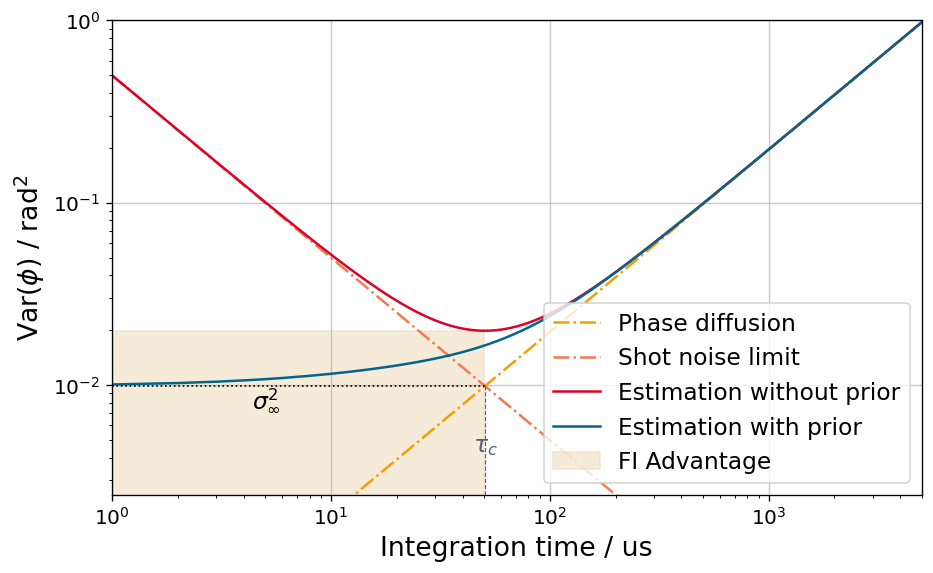

In [50]:
# 把字体调大 
plt.rcParams.update({
    'font.size': 14,          # 全局默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 12,    # x轴刻度字体大小
    'ytick.labelsize': 12,    # y轴刻度字体大小
    'legend.fontsize': 14     # 图例字体大小
})
bandwith_tau=1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP))
mu=SIG_AMP*2
phase_var_limit=PHASE_SEEPD/np.sqrt(2*SIG_AMP)
adv_up=phase_var_limit*2
adv_low=phase_var_limit*1e-5 
phase_diffusion=(PHASE_SEEPD*np.sqrt(time_axis))**2
plt.figure(figsize=(8,5),dpi=120)
plt.plot(time_axis,func_diffusion(time_axis,mu),'-.',label='Phase diffusion',color=c3)
plt.plot(time_axis[1:],func_shot_noise(time_axis[1:],mu),'-.',label='Shot noise limit',color=c4)
# plt.plot(time_exposure_list[1:-1],m1_std_mean_list[1:-1]**2,'o',label='Without prior',color=c5)
plt.loglog(time_axis,func_without_prior(time_axis,mu),'-',color=c5,label='Estimation without prior')
# plt.plot(time_exposure_list[:-1],m4_std_mean_list[:-1]**2,'^',label='With prior',color=c2)
plt.loglog(time_axis,func_with_prior(time_axis,mu),'-',color=c2,label='Estimation with prior')
# plt.vlines(bandwith_tau,25e-4,1,linestyles='--',label='Bandwidth',color='C1')
plt.hlines(phase_var_limit,1,bandwith_tau,linestyles=':',color='k',linewidth=1)
plt.text(bandwith_tau*1e-1, phase_var_limit, '$\sigma_{\infty}^2$', ha='center', va='top', fontsize=14,color='k')

# 区域
plt.fill_between(time_axis[time_axis<=bandwith_tau],adv_low,adv_up,color=c1_,alpha=0.6,label='FI Advantage')
plt.vlines(bandwith_tau, 25e-4, phase_var_limit, linestyles='--', color=c2_,linewidth=0.7)
plt.text(bandwith_tau, 40e-4, '$τ_{c}$', ha='center', va='bottom', fontsize=14,color=c2_)
plt.xscale('log')
plt.yscale('log')
plt.ylim(25e-4,1)
plt.xlim(1,5e3)
plt.legend(loc='lower right')
plt.grid(alpha=0.7)
plt.xlabel('Integration time / us')
plt.ylabel('Var($\\phi$) / rad$^2$')
plt.tight_layout()
# plt.savefig('Fig2_simu.pdf',dpi=1000,bbox_inches='tight')
# text0='Simulation number:{}, Exposure(measure) time:{}us \n'.format(RAND_NUM,time_exposure)
# text1='When time is {:,.2f}us, theory phase equal shot noise'.format(1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP)))
# plt.title(text0+text1)

plt.show()

## 3d图

C:\Users\yf210\AppData\Local\Temp\ipykernel_16016\4164934731.py:108: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


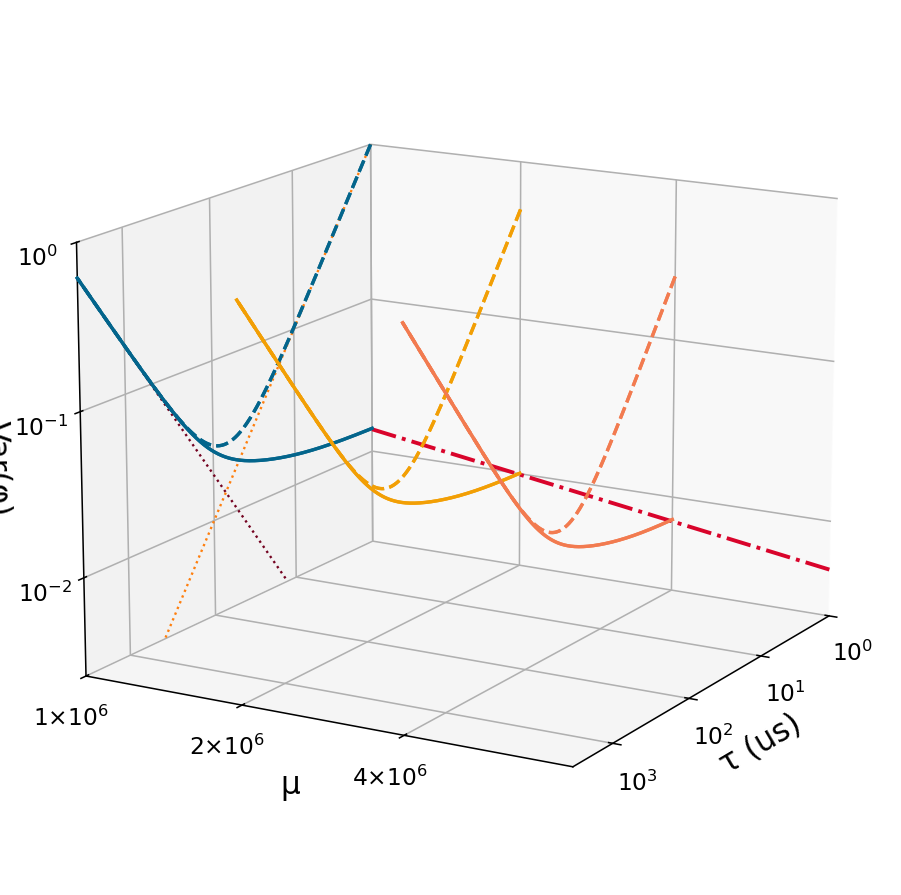

In [51]:
# 3D 曲线：以 tau 为横轴、mu 为纵轴、函数值为 z，仅显示 4 条曲线
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# 采样范围
tau = np.linspace(1, 10**3.5, 40000)  # ~[1, 5e3] 与前文一致
mu_list = [SIG_AMP*1, SIG_AMP*2, SIG_AMP*2*2]#, SIG_AMP*2*2*2]  # 选两组 mu，组合两种函数=4条曲线

fig = plt.figure(figsize=(8, 9), dpi=140)
ax = fig.add_subplot(111, projection='3d')

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5','C6']
colors = [c2,c3,c4, 'C5', 'C4', 'C5','C6']
labels = []
colors_dict = {}

# 生成六条曲线：三条 without_prior + 三条 with_prior
curves = []
for i, mu_i in enumerate(mu_list):
    z1 = func_without_prior(tau, mu_i)
    z2 = func_with_prior(tau, mu_i)
    curves.append(('Without prior', mu_i, tau, z1,'--'))
    curves.append(('With prior',    mu_i, tau, z2,'-'))
    colors_dict[mu_i]=colors[i]

for idx, (kind, mu_i, x_tau, z_val, linestyle) in enumerate(curves[:2*len(mu_list)]):
    # y 轴常值为 mu_i，用同长度数组表示一条“沿 tau”的曲线
    y_mu = np.full_like(x_tau, mu_i)
    ax.plot(np.log10(x_tau), np.log10(y_mu), np.log10(z_val), lw=1.7, color=colors_dict[mu_i],
            label=f'{kind}, μ={mu_i:.2f}',linestyle=linestyle)

# y 轴范围 mu
_mu_min=np.log10(mu_list[0])
_mu_max=np.log10(mu_list[-1]*2)
# x 轴范围 tau
_x_min,_x_max=0,3.5

# 在 yz 平面上添加 func_sigma_inf 曲线
_mu_l=np.linspace(10**_mu_min,10**(_mu_max),1000)
z_sigma_info = func_sigma_inf(tau, _mu_l)
_index_si=(z_sigma_info>=10**(-2.6)) & (z_sigma_info<=10**(0))
ax.plot(np.full_like(_mu_l[_index_si], 0), np.log10(_mu_l[_index_si]), np.log10(z_sigma_info[_index_si]),
        lw=2, color=c5, label=f'sigma_inf',linestyle='-.')
ax.set_ylim3d(_mu_min, _mu_max)

# 在 xy 平面添加 func_tau_opt 曲线
z_tau_opt = func_tau_opt(_mu_l)
# ax.plot(np.log10(z_tau_opt),np.log10(_mu_l), np.full_like(_mu_l, -2.6),
#         lw=1.8, color='C4', label=f'tau_opt')
ax.set_zlim3d(-2.6,0)
#在 xy 平面添加 counter




# 在 xz 平面上添加 func_diffusion 
# 生成 func_diffusion 曲线
z_min,z_max=ax.get_zlim3d()
_tau_l=np.linspace(1,10**(_x_max),1000)
z_diffusion = func_diffusion(_tau_l, 0)
_index=(z_diffusion>=10**(z_min)) & (z_diffusion<=10**(z_max))
ax.plot(np.log10(_tau_l[_index]), np.full_like(_tau_l[_index], _mu_min), np.log10(z_diffusion[_index]),
        lw=1.2, color=c1, label=f'Diffusion, σ={SIG_AMP:.2f}',linestyle=':')
### xz 平面上添加 func_shot_noise
z_shot_noise=func_shot_noise(_tau_l,mu_list[0])
_index_sn=(z_shot_noise>=10**(z_min)) & (z_shot_noise<=10**(z_max))
ax.plot(np.log10(_tau_l[_index_sn]), np.full_like(_tau_l[_index_sn], _mu_min), np.log10(z_shot_noise[_index_sn]),
        lw=1.2, color='C1', label=f'Shot noise, σ={SIG_AMP:.2f}',linestyle=':')
ax.set_xlim3d(_x_min,_x_max)

for idx, (kind, mu_i, x_tau, z_val, linestyle) in enumerate(curves[:6]):
    # y 轴常值为 mu_i，用同长度数组表示一条“沿 tau”的曲线
    y_mu = np.full_like(x_tau, mu_i)
    ax.plot(np.log10(x_tau), np.log10(y_mu), np.log10(z_val), lw=1.7, color=colors_dict[mu_i],
            label=f'{kind}, μ={mu_i:.2f}',linestyle=linestyle)



# 轴标签与样式
ax.set_xlabel('τ (us)')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'])

ax.set_ylabel('μ')
ax.set_yticks([np.log10(mu) for mu in mu_list])
ax.set_yticklabels([f'{mu:.0f}$\\times 10^6$' for mu in mu_list])

ax.set_zlabel('Var(φ)')
ax.set_zticks([0,-1,-2])
ax.set_zticklabels([f'$10^{{{z:.0f}}}$' for z in ax.get_zticks()])

# 视角和比例
ax.view_init(elev=15, azim=30, roll=0)
ax.set_box_aspect((1, 1.0,0.8))

# ax.xaxis.pane.fill = False
# ax.yaxis.pane.fill = False
# ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
ax.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))


# 图例两列显示
# ax.legend(ncol=2, loc='upper left', bbox_to_anchor=(0.0, 1.02))
plt.tight_layout()
plt.show()

# 2 IN 1

var vs tau

C:\Users\yf210\AppData\Local\Temp\ipykernel_16016\1875387888.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1/(mu*tau*np.exp(-D*tau)*V0*V0)+func_diffusion(tau,mu,D)


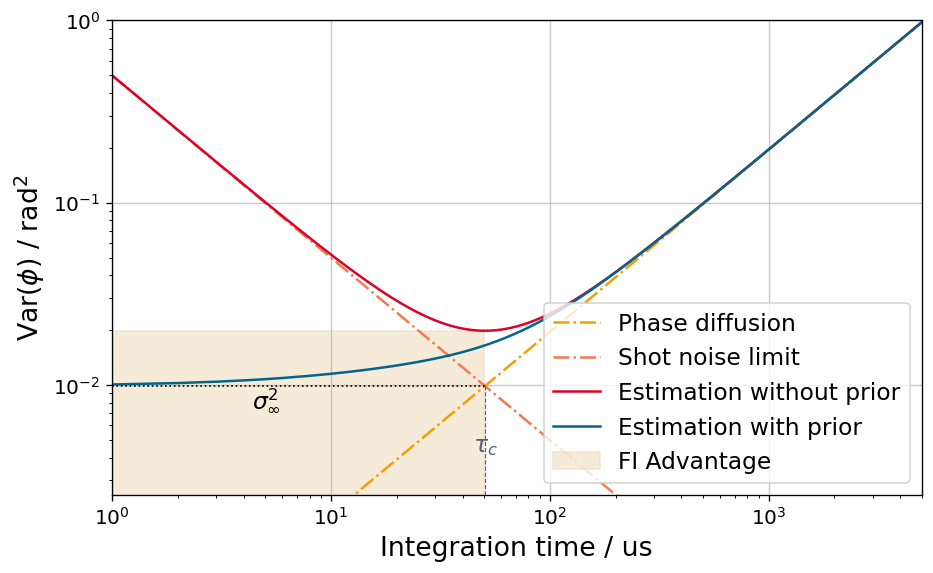

In [52]:
# 把字体调大 
plt.rcParams.update({
    'font.size': 14,          # 全局默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 12,    # x轴刻度字体大小
    'ytick.labelsize': 12,    # y轴刻度字体大小
    'legend.fontsize': 14     # 图例字体大小
})
bandwith_tau=1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP))
mu=SIG_AMP*2
phase_var_limit=PHASE_SEEPD/np.sqrt(2*SIG_AMP)
adv_up=phase_var_limit*2
adv_low=phase_var_limit*1e-5 
phase_diffusion=(PHASE_SEEPD*np.sqrt(time_axis))**2
plt.figure(figsize=(8,5),dpi=120)
plt.plot(time_axis,func_diffusion(time_axis,mu),'-.',label='Phase diffusion',color=c3)
plt.plot(time_axis[1:],func_shot_noise(time_axis[1:],mu),'-.',label='Shot noise limit',color=c4)
# plt.plot(time_exposure_list[1:-1],m1_std_mean_list[1:-1]**2,'o',label='Without prior',color=c5)
plt.loglog(time_axis,func_without_prior(time_axis,mu),'-',color=c5,label='Estimation without prior')
# plt.plot(time_exposure_list[:-1],m4_std_mean_list[:-1]**2,'^',label='With prior',color=c2)
plt.loglog(time_axis,func_with_prior(time_axis,mu),'-',color=c2,label='Estimation with prior')
# plt.vlines(bandwith_tau,25e-4,1,linestyles='--',label='Bandwidth',color='C1')
plt.hlines(phase_var_limit,1,bandwith_tau,linestyles=':',color='k',linewidth=1)
plt.text(bandwith_tau*1e-1, phase_var_limit, '$\sigma_{\infty}^2$', ha='center', va='top', fontsize=14,color='k')

# 区域
plt.fill_between(time_axis[time_axis<=bandwith_tau],adv_low,adv_up,color=c1_,alpha=0.6,label='FI Advantage')
plt.vlines(bandwith_tau, 25e-4, phase_var_limit, linestyles='--', color=c2_,linewidth=0.7)
plt.text(bandwith_tau, 40e-4, '$τ_{c}$', ha='center', va='bottom', fontsize=14,color=c2_)
plt.xscale('log')
plt.yscale('log')
plt.ylim(25e-4,1)
plt.xlim(1,5e3)
plt.legend(loc='lower right')
plt.grid(alpha=0.7)
plt.xlabel('Integration time / us')
plt.ylabel('Var($\\phi$) / rad$^2$')
plt.tight_layout()
# plt.savefig('Fig2_simu.pdf',dpi=1000,bbox_inches='tight')
# text0='Simulation number:{}, Exposure(measure) time:{}us \n'.format(RAND_NUM,time_exposure)
# text1='When time is {:,.2f}us, theory phase equal shot noise'.format(1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP)))
# plt.title(text0+text1)

plt.show()

var vs mu

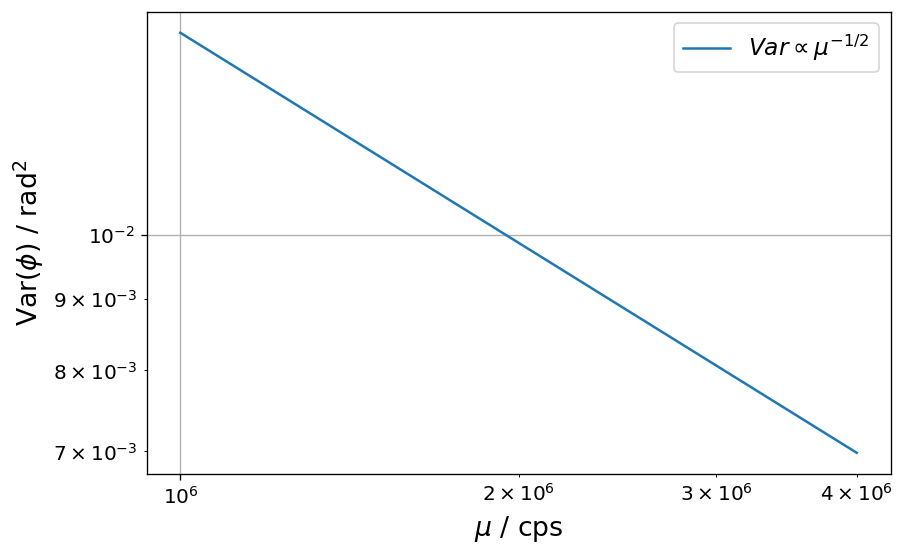

In [53]:
mu_array=np.linspace(1,SIG_AMP*2*2,10000)
sigma_inf_array=func_sigma_inf(1e1, mu_array)
plt.figure(figsize=(8,5),dpi=120)
plt.loglog(mu_array*1e6,sigma_inf_array,label='$Var \\propto \\mu^{-1/2}$')
plt.xlabel('$\\mu$ / cps')
plt.ylabel('Var($\\phi$) / rad$^2$')
plt.grid()
plt.legend()

C:\Users\yf210\AppData\Local\Temp\ipykernel_16016\1875387888.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1/(mu*tau*np.exp(-D*tau)*V0*V0)+func_diffusion(tau,mu,D)
C:\Users\yf210\AppData\Local\Temp\ipykernel_16016\1090784312.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


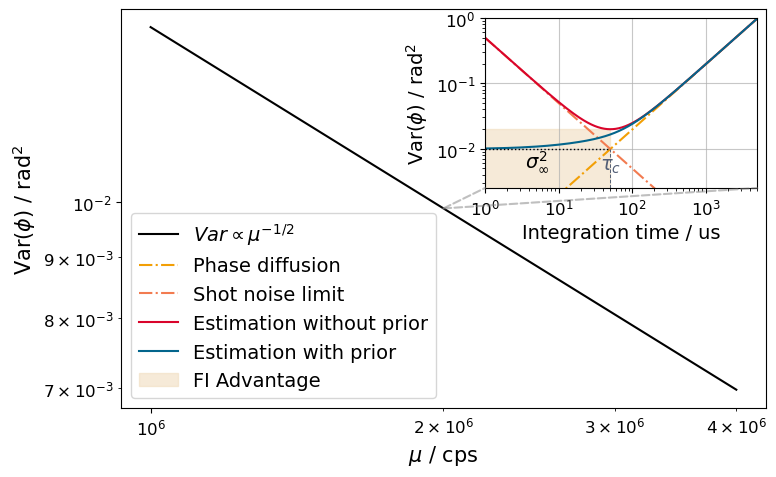

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.patches as patches



fig, ax1 = plt.subplots(figsize=(8,5),dpi=100)
mu_array=np.linspace(1,SIG_AMP*2*2,10000)
sigma_inf_array=func_sigma_inf(1e1, mu_array)
# 绘制数据并保存返回值以获取句柄
vis_line = ax1.loglog(mu_array*1e6,sigma_inf_array,label='$Var \\propto \\mu^{-1/2}$',color='k')
# ax1.grid('both')

# 设置轴的颜色
# ax1.tick_params(axis='y', colors=c2)
# ax1.spines['left'].set_color(c2)

# 设置轴标签和范围
ax1.set_xlabel('$\\mu$ / cps', fontsize=15)
ax1.set_ylabel('Var($\\phi$) / rad$^2$', fontsize=15)
# ax1.set_ylim(0.9+0.01,1.1+0.01)


# 用红色方框圈出visibility散点图的第二个点
# 获取第二个点的坐标（索引为1）
second_point_x = SIG_AMP*2*1e6  # 第二个点的 x 坐标
second_point_y = func_sigma_inf(1e1, second_point_x/1e6)



# 5. 创建嵌入图（副图）
ax_inset = fig.add_axes([0.62, 0.6, 0.34, 0.34])  # [left, bottom, width, height]

# 绘制副图：时间符合直方图
ax_inset.plot(time_axis,func_diffusion(time_axis,mu),'-.',label='Phase diffusion',color=c3)
ax_inset.plot(time_axis[1:],func_shot_noise(time_axis[1:],mu),'-.',label='Shot noise limit',color=c4)
ax_inset.loglog(time_axis,func_without_prior(time_axis,mu),'-',color=c5,label='Estimation without prior')
ax_inset.loglog(time_axis,func_with_prior(time_axis,mu),'-',color=c2,label='Estimation with prior')
ax_inset.hlines(phase_var_limit,1,bandwith_tau,linestyles=':',color='k',linewidth=1)
ax_inset.text(bandwith_tau*1e-1, phase_var_limit, '$\sigma_{\infty}^2$', ha='center', va='top', fontsize=14,color='k')

# 区域
ax_inset.fill_between(time_axis[time_axis<=bandwith_tau],adv_low,adv_up,color=c1_,alpha=0.6,label='FI Advantage')
ax_inset.vlines(bandwith_tau, 25e-4, phase_var_limit, linestyles='--', color=c2_,linewidth=0.7)
ax_inset.text(bandwith_tau, 40e-4, '$τ_{c}$', ha='center', va='bottom', fontsize=14,color=c2_)
ax_inset.set_xscale('log')
ax_inset.set_yscale('log')
ax_inset.set_ylim(25e-4,1)
ax_inset.set_xlim(1,5e3)
# ax_inset.legend(loc='lower right', fontsize=14)
ax_inset.grid(alpha=0.7)
ax_inset.set_xlabel('Integration time / us', fontsize=14)
ax_inset.set_ylabel('Var($\\phi$) / rad$^2$', fontsize=14)

# 添加灰色虚线连接主图中的红色方框和子图，表示子图是该区域的放大
# 使用更可靠的方法创建连接线
# 从红色方框中心到子图左下角和右下角
# 创建两条灰色虚线连接
# 合并所有图例
lines_labels = [ax1.get_legend_handles_labels(),ax_inset.get_legend_handles_labels()]
lines = [h for handles, labels in lines_labels for h in handles]
labels = [l for handles, labels in lines_labels for l in labels]
ax1.legend(lines, labels,loc='lower left')  # 可以根据需要调整位置

# 从方框到子图的两条连接线
# 使用ConnectionPatch的正确参数
con1 = patches.ConnectionPatch(
    xyA=(second_point_x, (second_point_y)),  # 主图中红色方框上边缘中点
    xyB=(0, 0),  # 子图的左上角（归一化坐标）
    coordsA="data",  # 主图使用数据坐标
    coordsB="axes fraction",  # 子图使用归一化坐标
    axesA=ax1,  # 主图坐标轴
    axesB=ax_inset,  # 子图坐标轴
    linestyle='--',
    color='gray',
    alpha=0.5,
    linewidth=1.5
)

con2 = patches.ConnectionPatch(
    xyA=(second_point_x, (second_point_y)),  # 主图中红色方框上边缘中点
    xyB=(1, 0),  # 子图的右上角（归一化坐标）
    coordsA="data",  # 主图使用数据坐标
    coordsB="axes fraction",  # 子图使用归一化坐标
    axesA=ax1,  # 主图坐标轴
    axesB=ax_inset,  # 子图坐标轴
    linestyle='--',
    color='gray',
    alpha=0.5,
    linewidth=1.5
)

# 添加连接线到图形
fig.add_artist(con1)
fig.add_artist(con2)

# 6. 美化图表
plt.tight_layout()
plt.show()